# timeseries files usage, case metadata generated from raw directory

In [1]:
import os
import os.path
import pprint
import warnings

from dask_jobqueue import PBSCluster
from distributed import Client
from distributed.worker import get_client
import intake

from esm_catalog_utils import directory_to_esm_datastore

In [2]:
%load_ext autoreload
%autoreload 2

## Specification of Input

In [3]:
directory = "/glade/campaign/cesm/development/bgcwg/projects/GCB_2022/g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.GCB_2022.BDRD.001"

## Obtain Computational Resources

In [4]:
user = os.getenv('USER')
logdir = f'/glade/scratch/{user}/dask_tmp'
with warnings.catch_warnings():
    warnings.filterwarnings(action="ignore", message=".*already in use", module=".*node")
    cluster = PBSCluster(
        cores = 1,
        memory = '4GiB',
        processes = 1,
        local_directory = logdir,
        log_directory = logdir,
        resource_spec = 'select=1:ncpus=1:mem=4GB',
        queue = 'casper',
        account = 'P93300070',
        walltime = '0:30:00',
        interface = 'ib0',
    )

cluster.scale(12)

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/klindsay/esm_catalog_utils/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/klindsay/esm_catalog_utils/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.45:36790,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/klindsay/esm_catalog_utils/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Generate and save catalog

In [5]:
%%time
print("creating esm_datastore")
esm_datastore = directory_to_esm_datastore(directory, use_dask=True)
print(esm_datastore)

creating esm_datastore
generating esm_datastore for g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.GCB_2022.BDRD.001
<sample catalog with 5 dataset(s) from 6180 asset(s)>
CPU times: user 12 s, sys: 804 ms, total: 12.8 s
Wall time: 1min 13s


In [6]:
df = esm_datastore.df
vals = df.frequency.unique() 
print(vals)

['month_1' 'day_1' 'year_1']


In [7]:
case = os.path.basename(directory)
datastore_directory = os.path.join(os.getcwd(), "generated")
os.makedirs(datastore_directory, exist_ok=True)
esm_datastore.serialize(name=case, directory=datastore_directory, catalog_type="file")

Successfully wrote ESM catalog json file to: file:///glade/work/klindsay/analysis/esm_catalog_utils/notebooks/generated/g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.GCB_2022.BDRD.001.json


## Generate catalog, in update mode

In [8]:
%%time
path = os.path.join(datastore_directory, f"{case}.json")
print("updating esm_datastore")
esm_datastore = intake.open_esm_datastore(path)
print(esm_datastore)
esm_datastore = directory_to_esm_datastore(
    directory, esm_datastore_in=esm_datastore, use_dask=True
)
print(esm_datastore)

updating esm_datastore
<g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.GCB_2022.BDRD.001 catalog with 5 dataset(s) from 6180 asset(s)>
appending esm_datastore for g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.GCB_2022.BDRD.001
<g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.GCB_2022.BDRD.001 catalog with 5 dataset(s) from 6180 asset(s)>
CPU times: user 5.46 s, sys: 134 ms, total: 5.59 s
Wall time: 5.9 s


## Load catalog, and perform a computation

In [9]:
esm_datastore = intake.open_esm_datastore(path)
print(esm_datastore)
esm_datastore.df.columns

<g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.GCB_2022.BDRD.001 catalog with 5 dataset(s) from 6180 asset(s)>


Index(['case', 'scomp', 'component', 'path', 'stream', 'datestring',
       'frequency', 'date_start', 'date_end', 'varname', 'size'],
      dtype='object')

In [10]:
df = esm_datastore.df
vals = df.frequency.unique() 
print(vals)

['month_1' 'day_1' 'year_1']


In [11]:
varname = 'FG_CO2_2'

In [12]:
subset = esm_datastore.search(frequency='day_1', varname=varname)
print(subset)

<g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.GCB_2022.BDRD.001 catalog with 1 dataset(s) from 10 asset(s)>


In [13]:
%%time
with warnings.catch_warnings():
    warnings.filterwarnings(
        action="ignore", message=".*single-machine", module=".*base"
    )
    ds_dict = subset.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'case.scomp.component.stream.frequency'


CPU times: user 2.52 s, sys: 217 ms, total: 2.73 s
Wall time: 3.8 s


In [14]:
key = list(ds_dict)[0]
ds = ds_dict[key]
ds

<xarray.Dataset>
Dimensions:                 (z_t: 60, z_t_150m: 15, z_w: 60, z_w_top: 60,
                             z_w_bot: 60, nlat: 384, nlon: 320, time: 87600,
                             d2: 2)
Coordinates: (12/61)
  * z_t                     (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m                (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
  * z_w                     (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_top                 (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot                 (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
    dz                      (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    ...                      ...
    salinity_factor         float64 -0.00347
    sflux_factor            float64 0.1
    nsurface_t              float64 8.61e+04
    nsurface_u              float64 8.297e+04
    time_bound              (time, d2) object dask.array<chunksize=(9125, 2), meta=np.ndarray>
  * time                    (time) object 1778-01-02 00:00:00 ... 2018-01-01 ...
Dimensions without coordinates: nlat, nlon, d2
Data variables:
    FG_CO2_2                (time, nlat, nlon) float32 dask.array<chunksize=(9125, 384, 320), meta=np.ndarray>
Attributes: (12/19)
    title:                           g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17...
    history:                         none
    Conventions:                     CF-1.0; http://www.cgd.ucar.edu/cms/eato...
    time_period_freq:                day_1
    model_doi_url:                   https://doi.org/10.5065/D67H1H0V
    contents:                        Diagnostic and Prognostic Variables
    ...                              ...
    intake_esm_attrs:component:      ocn
    intake_esm_attrs:stream:         h.ecosys.nday1
    intake_esm_attrs:frequency:      day_1
    intake_esm_attrs:varname:        FG_CO2_2
    intake_esm_attrs:_data_format_:  netcdf
    intake_esm_dataset_key:          g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17...

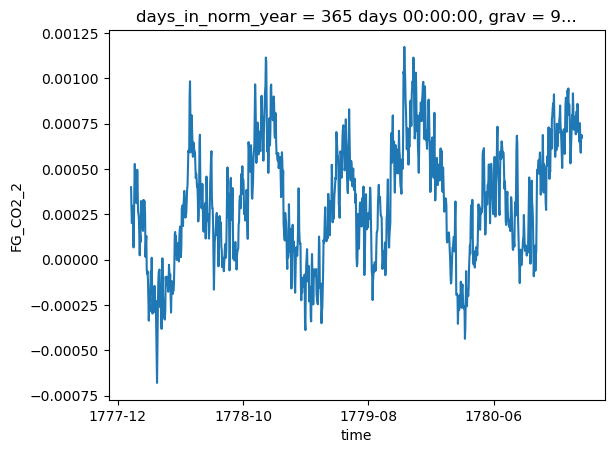

In [15]:
dims = ds[varname].dims[-2:]
ds[varname].isel(time=slice(0, 365*3)).mean(dims).plot()

## Release Computational Resources

In [16]:
client.close()
cluster.close()